In [1]:
from decouple import config
from mvpa_functions import load_pickle, ados
import nilearn.plotting as nplot
import os
import re
from nilearn.reporting import get_clusters_table
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np

In [2]:
test_eft = ados('G2', test_train='train', directory='t2')

## Read in model and test images

In [8]:
path_to_models = os.path.join(config('ml'), 'pickle', 'test_train_cv_10')
test_parameters = ados('G2' , mean_images=True, test_train='test').reset_index(drop=True)
train_parameters = ados('G2', mean_images=True, test_train='train').drop([20])
ml_models = dict(zip([re.sub('.pickle', '', key) for key in os.listdir(path_to_models)], 
                     [load_pickle(re.sub('\.pickle', '', os.path.join(path_to_models, pickle))) for pickle in os.listdir(path_to_models)]))

SyntaxError: unexpected EOF while parsing (201125826.py, line 5)

## Plot weights

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


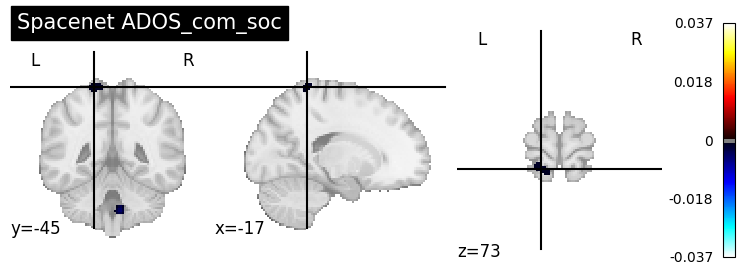

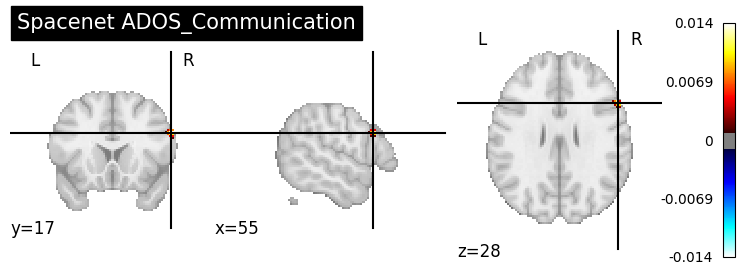

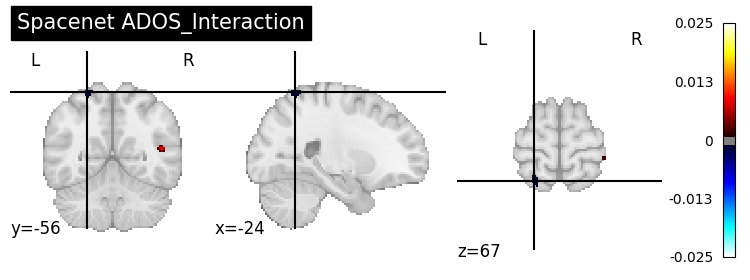

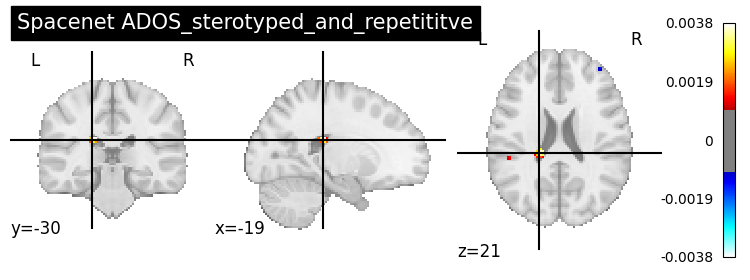

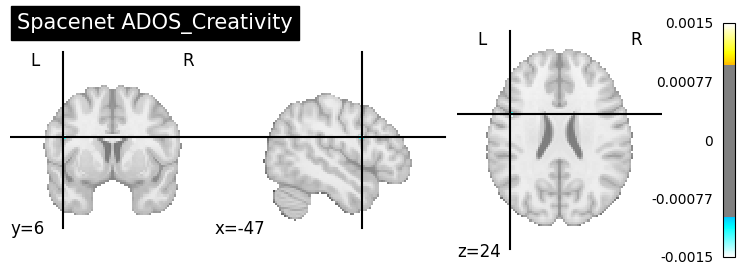

In [4]:
for domain in ml_models:
    nplot.plot_stat_map(
        ml_models[domain].coef_img_,
        title=f"Spacenet {domain}",
        threshold=0.001
    )

## Calculate performance metrics

In [5]:
%%capture
test_stats =  dict(zip([key for key in ml_models.keys()], [{} for key in ml_models.keys()]))

for model in test_stats.keys():
    test_stats[model]['y_pred'] = ml_models[model].predict(test_parameters['paths']).ravel()
    test_stats[model]['r2'] = ml_models[model].score(test_parameters['paths'], test_parameters[model])
    test_stats[model]['mse'] = np.mean(np.abs(test_parameters[model] - test_stats[model]['y_pred']))

In [6]:
for model in test_stats.keys():
    cv_scores = np.delete(ml_models[model].cv_scores_.ravel(), np.where(ml_models[model].cv_scores_.ravel() < -100 ))
    cv_scores = cv_scores[~np.isnan(cv_scores)]
    print(f'Mean scores for misclassified alpha for {model}', cv_scores.mean())
    print(f"Mean square error for {model}: {test_stats[model]['mse']}")
    print(f"R2 for {model}: {test_stats[model]['r2']}\n")

Mean scores for misclassified alpha for ADOS_com_soc 0.21548230746250843
Mean square error for ADOS_com_soc: 2.0676627854710983
R2 for ADOS_com_soc: -0.041976314973075635

Mean scores for misclassified alpha for ADOS_Communication 0.09740759229674074
Mean square error for ADOS_Communication: 1.357233030861741
R2 for ADOS_Communication: 0.022744835616790304

Mean scores for misclassified alpha for ADOS_Interaction 0.1253818050484709
Mean square error for ADOS_Interaction: 0.8664021418124005
R2 for ADOS_Interaction: -1.8357421491796782

Mean scores for misclassified alpha for ADOS_sterotyped_and_repetititve 0.07113830966347835
Mean square error for ADOS_sterotyped_and_repetititve: 1.2214303034865959
R2 for ADOS_sterotyped_and_repetititve: -0.43604958080578116

Mean scores for misclassified alpha for ADOS_Creativity 0.48948858479997115
Mean square error for ADOS_Creativity: 0.49952627828960205
R2 for ADOS_Creativity: -0.07785716989720926



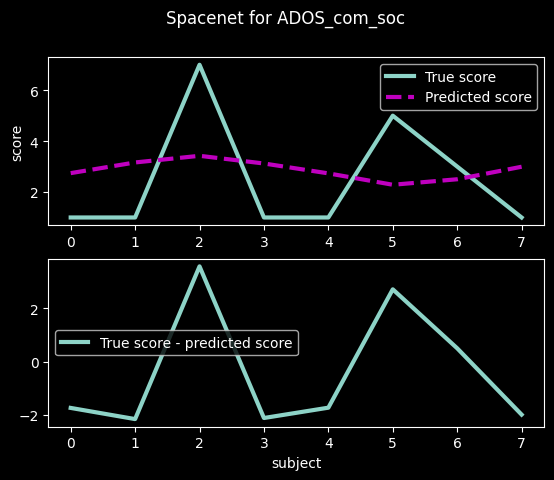

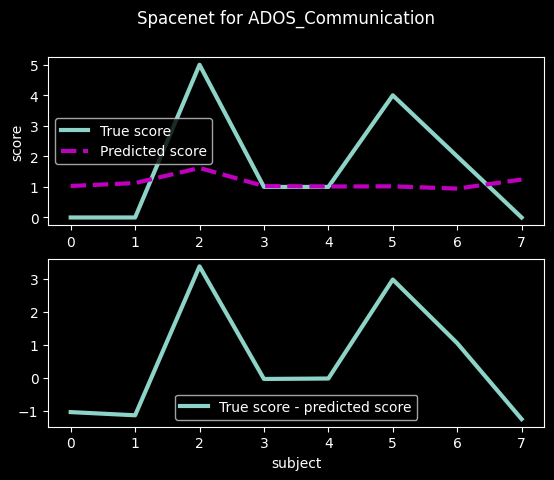

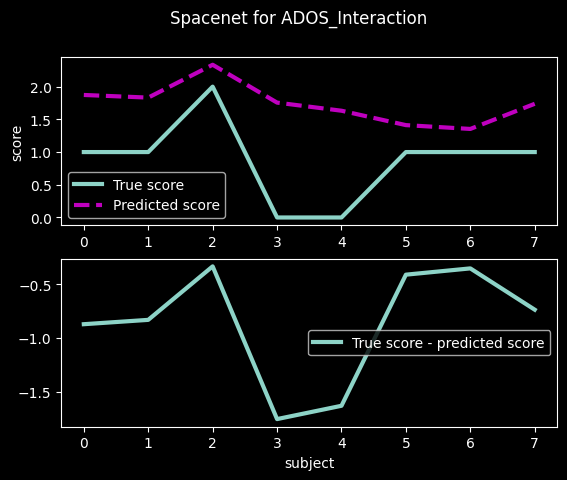

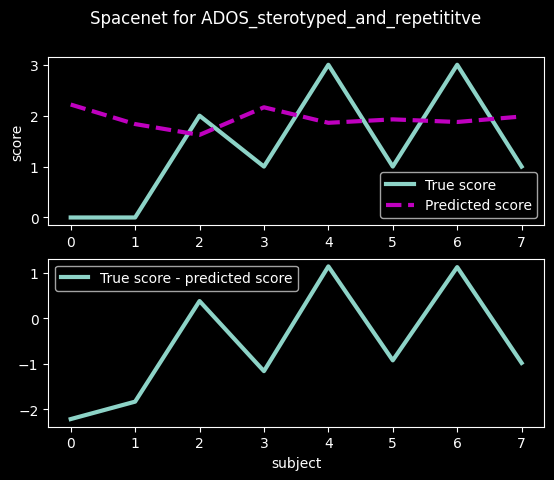

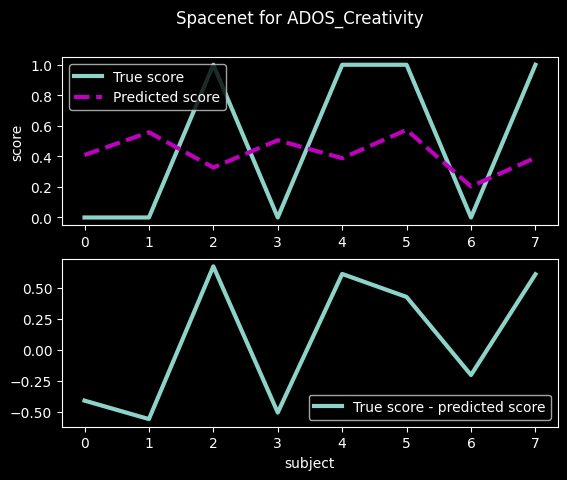

In [7]:
for model in test_stats.keys():
    plt.figure()
    plt.suptitle(f"Spacenet for {model} ")
    ax1 = plt.subplot(211)
    ax1.plot(test_parameters[model], label="True score", linewidth=3)
    ax1.plot(test_stats[model]['y_pred'], "--", c="m", label="Predicted score", linewidth=3)
    ax1.set_ylabel("score")
    plt.legend(loc="best")
    ax2 = plt.subplot(212)
    ax2.plot(
        test_parameters[model] - test_stats[model]['y_pred'], label="True score - predicted score", linewidth=3
    )
    ax2.set_xlabel("subject")
    plt.legend(loc="best")